In [1]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns

from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
ligand_file = "kraken_DFT.xlsx"

In [3]:
ligands = pd.read_excel(ligand_file,
                       header=0,
                       index_col=False,
                       keep_default_na=True
                       )


In [4]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [5]:
ligands = ligands[['spindens_P_ra_boltz',
                   'fukui_p_boltz',
                   'nbo_bd_occ_avg_boltz',
                   'nbo_bd_occ_min_boltz',
                   'nbo_bds_e_avg_boltz',
                   'nbo_bds_e_min_boltz']]
          
        
ligands.head()

,spindens_P_ra_boltz,fukui_p_boltz,nbo_bd_occ_avg_boltz,nbo_bd_occ_min_boltz,nbo_bds_e_avg_boltz,nbo_bds_e_min_boltz
0,0.039934,0.039065,1.953641,1.947840,0.213487,0.203064
1,0.014649,0.014265,1.952816,1.947097,0.219230,0.211338
2,0.020078,0.015795,1.953556,1.947707,0.219849,0.209768
3,0.024511,0.022227,1.953687,1.947043,0.221013,0.210561
4,0.013872,0.013581,1.953787,1.947589,0.210771,0.200092


In [6]:
ligands = clean_dataset(ligands)

In [7]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

In [15]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=6,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

In [16]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [17]:
pipe.fit(ligands)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=6, n_init=50,
                                         random_state=42))]))])

/Users/tht13/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


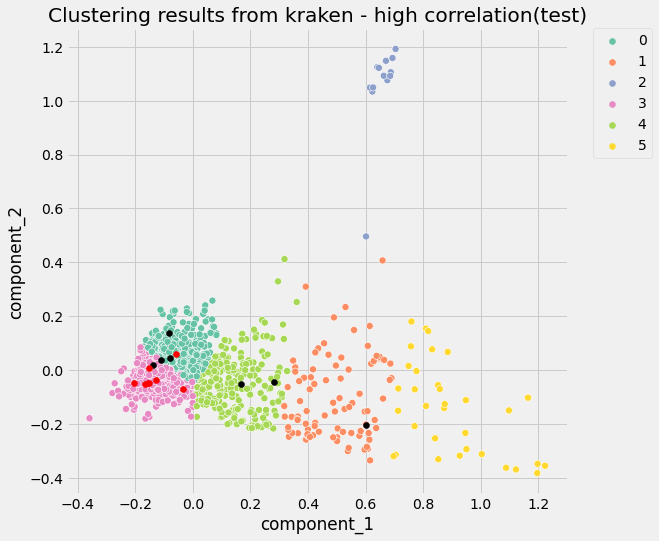

In [21]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(ligands),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    palette="Set2",
)

scat.set_title(
    "Clustering results from kraken - high correlation(test)"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

positive = [132,238,7,15,473,740,186]
negative = [13,111,60,8,61,17,53,16]

for i in positive:
    plt.scatter(pcadf.loc[i][0], pcadf.loc[i][1], color='Black')
    #plt.annotate(i, (pcadf.loc[i][0], pcadf.loc[i][1]))
for i in negative:
    plt.scatter(pcadf.loc[i][0], pcadf.loc[i][1], color='Red')
    #plt.annotate(i, (pcadf.loc[i][0], pcadf.loc[i][1]))

plt.show()

In [19]:
distortions = []
K = range(2,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(ligands)
    distortions.append(kmeanModel.inertia_)

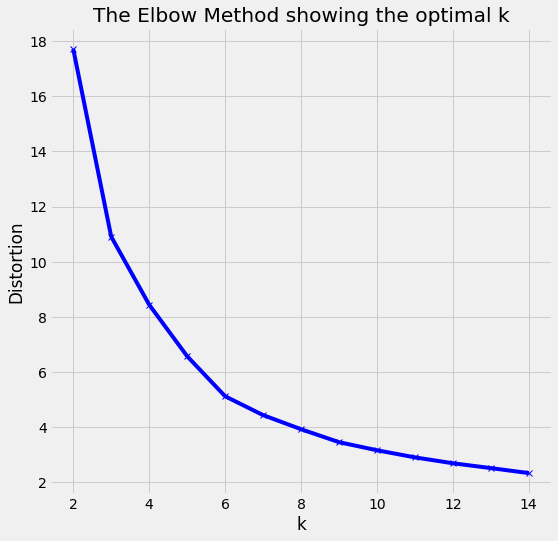

In [20]:
plt.figure(figsize=(8,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()